In [6]:
%cd ../

/Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC


In [7]:
from __future__ import print_function, division
import copy
import torch
import argparse
import numpy as np
import os
import umap
from torchvision import datasets, transforms
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score,\
f1_score, roc_auc_score, roc_curve, accuracy_score, matthews_corrcoef as mcc
from torch.utils.data import Subset
import pandas as pd
from scipy.spatial import distance_matrix

import argparse
import numpy as np
from scipy.cluster.vq import kmeans2
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torch.nn import Linear
from pytorchtools import EarlyStoppingCAC

import numbers
from sklearn.metrics import davies_bouldin_score as dbs, adjusted_rand_score as ari
from matplotlib import pyplot as plt
color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

from models import MultiHeadIDEC,  target_distribution, source_distribution
from utils import *

In [8]:
# Dataset parameters
params = {
'dir' : 'synthetic',
'dataset' : 'sepsis',

# Training parameters
'lr' : 0.002,
'alpha' : 1,
'wd' : 5e-4,
'batch_size' : 512,
'n_epochs' : 100,
'n_runs' : 1,
'pre_epoch' : 40,
'pretrain' : True,
"load_ae": False,
"classifier": "LR",
"tol": 0.01,
"attention": "True",
"ablation": 'None',
"cluster_balance": 'hellinger',
"verbose": 'True',

# Model parameters
'lamda' : 1,
'beta' : 0.5, # KL loss/KM loss weight
'gamma' : 1.5, # Classification loss weight
'delta' : 1, # Class Balance weight
'eta' : 0.0, # Class separation weight
'hidden_dims' : [64, 32],
'n_z' : 20,
'n_clusters' : 3,
'clustering' : 'cac',
'n_classes'  : 2,

# Utility parameters
'n_jobs' : 6,
'device' : 'cpu',
'log_interval' : 2,
'other' : 'False',
'cluster_balance' : 'hellinger',
'cluster_analysis' : 'False',
'pretrain_path': '/Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model'}
# 'pretrain_path': ''}


class parameters(object):
    def __init__(self, params):
        self.dir = params['dir']
        self.input_dim = -1
        self.dataset = params['dataset']
        
        # Training parameters
        self.lr = params['lr']
        self.alpha = params['alpha']
        self.wd = params['wd']
        self.batch_size = params['batch_size']
        self.n_epochs = params['n_epochs']
        self.n_runs = params['n_runs']
        self.pre_epoch = params['pre_epoch']
        self.pretrain = params['pretrain']
        self.load_ae = params['load_ae']
        self.classifier = params['classifier']
        self.tol = params['tol']
        self.attention = params['attention'] == "True"
        self.ablation = params['ablation']
        self.verbose = params['verbose']

        # Model parameters
        self.lamda = params['lamda']
        self.beta = params['beta']
        self.gamma = params['gamma']
        self.delta = params['delta']
        self.eta = params['eta']
        self.hidden_dims = params['hidden_dims']
        self.latent_dim = self.n_z = params['n_z']
        self.n_clusters = params['n_clusters']
        self.clustering = params['clustering']
        self.n_classes = params['n_classes']
        self.cluster_balance = params['cluster_balance']
        self.cluster_analysis = params['cluster_analysis']

        # Utility parameters
        self.n_jobs = params['n_jobs']
        self.device = params['device']
        self.log_interval = params['log_interval']
        self.other = params['other']
        self.pretrain_path = params['pretrain_path'] + "/" + self.dataset + ".pth"

args = parameters(params)
datasets = ['titanic', 'magic', 'creditcard', 'adult', 'diabetes',\
            'cic', 'sepsis', 'synthetic', 'paper_synthetic', 'aki', 'infant', 'wid_mortality']

In [9]:
base_suffix = ""

for key in ['n_clusters', 'alpha', 'beta', 'gamma', 'delta', 'eta']:
    print(key, args.__dict__[key])

base_suffix += args.dataset + "_"
base_suffix += str(args.n_clusters) + "_"
base_suffix += str(args.attention)

scale, column_names, train_data, val_data, test_data = get_train_val_test_loaders(args)
X_train, y_train, train_loader = train_data
X_val, y_val, val_loader = val_data
X_test, y_test, test_loader = test_data
# X_train = X_train[:,:42]
# args.input_dim = 42

n_clusters 3
alpha 1
beta 0.5
gamma 1.5
delta 1
eta 0.0
sepsis


In [16]:
column_names

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'hospital', 'ShockIndex', 'PartialSOFA',
       'MaxShockIndex', 'MinHR', '0_ShockIndex_HR', '1_ShockIndex_HR',
       '2_ShockIndex_HR', '3_ShockIndex_HR', '4_ShockIndex_HR',
       '5_ShockIndex_HR', '6_ShockIndex_HR', '7_ShockIndex_HR',
       '8_ShockIndex_HR', '9_ShockIndex_HR', '10_ShockIndex_HR',
       '11_ShockIndex_HR', '12_ShockIndex_HR', '13_ShockIndex_HR',
       '0_PartialSOFA_SBP', '1_PartialSOFA_SBP', '2_PartialSOFA_SBP',
       '3_PartialSOFA_SBP', '4_PartialSOFA_SBP', '5_PartialSOFA_SBP',
       '6_PartialSOFA_SBP', '7

In [10]:
####################################################################################
####################################################################################
####################################################################################
################################### Initialiation ##################################
####################################################################################
####################################################################################
####################################################################################

f1_scores, auc_scores, acc_scores = [], [], [] #Inattentive test results
e_f1_scores, e_auc_scores, e_acc_scores = [], [], [] #Attentive test results
sil_scores, wdfd_scores, nhfd_scores, w_nhfd_scores = [], [], [], []

# to track the training loss as the model trains
test_losses, e_test_losses, local_sum_test_losses = [], [], []
model_complexity = []

if args.ablation == "alpha":
    iter_array = alphas
    iteration_name = "Alpha"

elif args.ablation == "beta":
    iter_array = betas
    iteration_name = "Beta"

elif args.ablation == "gamma":
    iter_array = gammas
    iteration_name = "Gamma"

elif args.ablation == "delta":
    iter_array = deltas
    iteration_name = "Delta"

elif args.ablation == "k":
    iter_array = ks
    iteration_name = "K"

else:
    iter_array = range(args.n_runs)
    iteration_name = "Run"

for r in range(len(iter_array)):
    if args.verbose == 'False':
        blockPrint()

    print(iteration_name, ":", iter_array[r])

    if args.ablation == "beta":
        args.beta = iter_array[r]

    elif args.ablation == "gamma":
        args.gamma = iter_array[r]

    elif args.ablation == "delta":
        args.delta = iter_array[r]

    elif args.ablation == "k":
        args.n_clusters = iter_array[r]

    suffix = base_suffix + "_" + iteration_name + "_" + str(iter_array[r])

    ae_layers = [128, 64, 32, args.n_z, 32, 64, 128]
    model = MultiHeadIDEC(
            ae_layers,
            args=args).to(args.device)

    optimizer = Adam(model.parameters(), lr=args.lr)

    # cluster parameter initiate
    device = args.device
    y = y_train
    x_bar, hidden = model.ae(torch.Tensor(X_train).to(args.device))
    original_cluster_centers, cluster_indices = kmeans2(hidden.data.cpu().numpy(), k=args.n_clusters, minit='++')
    model.cluster_layer.data = torch.tensor(original_cluster_centers).to(device)
    criterion = nn.CrossEntropyLoss(reduction='none')


    ####################################################################################
    ####################################################################################
    ####################################################################################
    ################################## Clustering Step #################################
    ####################################################################################
    ####################################################################################
    ####################################################################################


    print("Starting Training")
    model.train()
    N_EPOCHS = args.n_epochs
    es = EarlyStoppingCAC(dataset=suffix)
    train_losses, e_train_losses = [], []

    for epoch in range(N_EPOCHS):
        # beta = args.beta*(epoch*0.1)/(1+epoch*0.1)
        beta = args.beta
        # gamma = args.gamma - args.gamma*(epoch*0.1)/(1+epoch*0.1)
        gamma = args.gamma
        delta = args.delta
        eta = args.eta
        if epoch % args.log_interval == 0:
            # plot(model, torch.FloatTensor(X_val).to(args.device), y_val, labels=None)
            model.ae.eval() # prep model for evaluation
            for j in range(model.n_clusters):
                model.classifiers[j][0].eval()

            z_train, _, q_train = model(torch.Tensor(X_train).to(args.device), output="decoded")
            q_train, q_train_p, q_train_n = q_train
            p_train = target_distribution(q_train.detach())

            # evaluate clustering performance
            cluster_indices = q_train.detach().cpu().numpy().argmax(1)
            preds = torch.zeros((len(z_train), args.n_classes))

            # Calculate Training Metrics
            nmi, acc, ari = 0, 0, 0
            train_loss = 0
            B = []

            for j in range(model.n_clusters):
                cluster_idx = np.where(cluster_indices == j)[0]
                X_cluster = z_train[cluster_idx]
                y_cluster = torch.Tensor(y_train[cluster_idx]).type(torch.LongTensor).to(model.device)

                # B.append(torch.max(torch.linalg.norm(X_cluster, axis=1), axis=0).values)
                cluster_preds = model.classifiers[j][0](X_cluster)
                train_loss += torch.sum(criterion(cluster_preds, y_cluster))

            train_loss /= len(z_train)
            # Evaluate model on Validation dataset
            qs, z_val = model(torch.FloatTensor(X_val).to(args.device), output="latent")
            q_val = qs[0]
            cluster_ids = torch.argmax(q_val, axis=1)
            preds = torch.zeros((len(z_val), args.n_classes))

            # Weighted predictions
            if args.attention == False:
                for j in range(model.n_clusters):
                    cluster_id = np.where(cluster_ids == j)[0]
                    X_cluster = z_val[cluster_id]
                    cluster_preds_val = model.classifiers[j][0](X_cluster)
                    preds[cluster_id,:] = cluster_preds_val

            else:
                for j in range(model.n_clusters):
                    X_cluster = z_val
                    cluster_preds = model.classifiers[j][0](X_cluster)
                    for c in range(args.n_classes):
                        preds[:,c] += q_val[:,j]*cluster_preds[:,c]

            # print("qval", torch.sum(q_val, axis=0))
            # print("Cluster Counts", np.bincount(cluster_ids))
            # print("KL div", torch.kl_div(torch.sum(q_val, axis=0),\
            #                         torch.ones(args.n_clusters)/args.n_clusters))

            # Classification Matrics
            val_f1  = f1_score(y_val, np.argmax(preds.detach().numpy(), axis=1), average="macro")
            val_auc = multi_class_auc(y_val, preds.detach().numpy(), args.n_classes)

            # Clustering Metrics
            val_sil = silhouette_new(z_val.data.cpu().numpy(), cluster_ids.data.cpu().numpy(), metric='euclidean')
            val_feature_diff, val_WDFD = 0, 0
            # val_feature_diff = calculate_nhfd(X_val, cluster_ids)
            # val_WDFD = calculate_WDFD(X_val, cluster_ids)
            complexity_term = 0
            # complexity_term  = calculate_bound(model, B, len(z_train))

            val_loss = torch.mean(criterion(preds, torch.Tensor(y_val).type(torch.LongTensor)))

            # # record validation loss
            # valid_losses.append(loss.item())

            # # calculate average loss over an epoch
            # valid_loss = np.average(valid_losses)
            # avg_valid_losses.append(valid_loss)

            epoch_len = len(str(N_EPOCHS))

            print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                         f'train_loss: {train_loss:.3f} ' +
                         f'valid_loss: {val_loss:.3f} '  +
                         f'valid_F1: {val_f1:.3f} '  +
                         f'valid_AUC: {val_auc:.3f} ' + 
                         f'valid_Feature_p: {val_feature_diff:.3f} ' + 
                         f'valid_WDFD: {val_WDFD:.3f} ' + 
                         f'valid_Silhouette: {val_sil:.3f} ' + 
                         f'Complexity Term: {complexity_term:.3f}')

            print(print_msg)

            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            es([val_f1, val_auc], model)
            if es.early_stop == True:
                break

        # Normal Training
        epoch_loss = 0
        epoch_balance_loss = 0
        epoch_class_loss = 0
        epoch_km_loss = 0
        
        model.ae.train() # prep model for evaluation
        for j in range(model.n_clusters):
            model.classifiers[j][0].train()

        for batch_idx, (x_batch, y_batch, idx) in enumerate(train_loader):
            total_loss = 0
            x_batch = x_batch.to(device)
            idx = idx.to(device)

            X_latents, x_bar, q_batch = model(x_batch)
            q_batch = q_batch[0]
            reconstr_loss = F.mse_loss(x_bar, x_batch)

            classifier_labels = np.zeros(len(idx))
            sub_epochs = min(10, 1 + int(epoch/5))

            if args.attention == False:
                classifier_labels = np.argmax(q_batch.detach().cpu().numpy(), axis=1)

            for _ in range(sub_epochs):
                # Choose classifier for a point probabilistically
                if args.attention == True:
                    for j in range(len(idx)):
                        classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q_batch[j].detach().numpy())

                for k in range(args.n_clusters):
                    idx_cluster = np.where(classifier_labels == k)[0]
                    X_cluster = X_latents[idx_cluster]
                    y_cluster = y_batch[idx_cluster]

                    classifier_k, optimizer_k = model.classifiers[k]
                    # Do not backprop the error to encoder
                    y_pred_cluster = classifier_k(X_cluster.detach())
                    cluster_loss = torch.mean(criterion(y_pred_cluster, y_cluster))
                    optimizer_k.zero_grad()
                    cluster_loss.backward(retain_graph=True)
                    optimizer_k.step()

            # Back propagate the error corresponding to last clustering
            class_loss = torch.tensor(0.).to(args.device)
            for k in range(args.n_clusters):
                idx_cluster = np.where(classifier_labels == k)[0]
                X_cluster = X_latents[idx_cluster]
                y_cluster = y_batch[idx_cluster]

                classifier_k, optimizer_k = model.classifiers[k]
                y_pred_cluster = classifier_k(X_cluster)
                class_loss += torch.sum(q_batch[idx_cluster,k]*criterion(y_pred_cluster, y_cluster))

            class_loss /= len(X_latents)
            delta_mu   = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
            cluster_id = torch.argmax(q_batch, 1)
            # print(np.bincount(cluster_id.cpu().numpy()))

            km_loss             = 0
            dcn_loss            = 0
            class_sep_loss      = 0

            if args.eta > 0:
                for j in range(args.n_clusters):
                    pts_index = np.where(cluster_id == j)[0]
                    cluster_pts = X_latents[pts_index]
                    delta_mu[j,:]   = cluster_pts.sum(axis=0)/(1+len(cluster_pts))
                    dcn_loss += torch.linalg.norm(X_latents[pts_index] - model.cluster_layer[j])/(1+len(cluster_pts))

            q_batch = source_distribution(X_latents, model.cluster_layer, alpha=model.alpha)
            P = torch.sum(torch.nn.Softmax(dim=1)(10*q_batch), axis=0)
            P = P/P.sum()
            Q = torch.ones(args.n_clusters)/args.n_clusters # Uniform distribution

            if args.cluster_balance == "kl":
                cluster_balance_loss = F.kl_div(P.log(), Q, reduction='batchmean')
            else:
                cluster_balance_loss = torch.linalg.norm(torch.sqrt(P) - torch.sqrt(Q))

            km_loss = F.kl_div(q_batch.log(), p_train[idx], reduction='batchmean')

            loss = reconstr_loss
            if args.beta != 0:
                loss += beta*km_loss
            if args.gamma != 0:
                loss += gamma*class_loss
            if args.delta != 0:
                loss += delta*cluster_balance_loss
            if args.eta != 0:
                loss += eta*dcn_loss

            epoch_loss += loss
            epoch_class_loss += class_loss
            epoch_balance_loss += cluster_balance_loss
            epoch_km_loss += km_loss
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

            # Update the positive and negative centroids
            if args.eta > 0:
                for j in range(args.n_clusters):
                    pts_index = np.where(cluster_id == j)[0]
                    N  = len(pts_index)
                    model.cluster_layer.data[j:] -= (1/(100+N))*delta_mu[j:]

        print('Epoch: {:02d} | Epoch KM Loss: {:.3f} | Total Loss: {:.3f} | Classification Loss: {:.3f} | Cluster Balance Loss: {:.3f}'.format(
                    epoch, epoch_km_loss, epoch_loss, epoch_class_loss, loss))
        train_losses.append([np.round(epoch_loss.item(),3), np.round(epoch_class_loss.item(),3)])

    ####################################################################################
    ####################################################################################
    ####################################################################################
    ################################### Local Training #################################
    ####################################################################################
    ####################################################################################
    ####################################################################################
    print('Train Losses: ', train_losses)
    print("\n####################################################################################\n")
    print("Training Local Networks")
    model = es.load_checkpoint(model)

    es = EarlyStoppingCAC(dataset=suffix)

    qs, z_train = model(torch.FloatTensor(np.array(X_train)).to(args.device), output="latent")
    q_train = qs[0]
    cluster_id_train = torch.argmax(q_train, axis=1)

    # X_latents_data_loader = list(zip(z_train, cluster_id_train, y_train))
    X_latents_data_loader = list(zip(z_train.to(args.device),q_train, y_train))

    train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
        batch_size=1024, shuffle=False)

    B = []

    # plot(model, torch.FloatTensor(np.array(X_train)).to(args.device), y_train,\
    #      torch.FloatTensor(np.array(X_test)).to(args.device), y_test)

    # Post clustering training
    for e in range(N_EPOCHS):
        epoch_loss = 0
        epoch_acc = 0
        epoch_f1 = 0
        acc = 0

        # model.ae.train() # prep model for evaluation
        for j in range(model.n_clusters):
            model.classifiers[j][0].train()

        # Full training of local networks
        for batch_idx, (X_latents, q_batch, y_batch) in enumerate(train_loader_latents):
            # torch.autograd.set_detect_anomaly(True)

            classifier_labels = np.zeros(len(X_latents))
            # Choose classifier for a point probabilistically
            if args.attention == True:
                for j in range(len(X_latents)):
                    classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q_batch[j].detach().numpy())
            else:
                classifier_labels = torch.argmax(q_batch, axis=1).data.cpu().numpy()

            for k in range(args.n_clusters):
                idx_cluster = np.where(classifier_labels == k)[0]
                X_cluster = X_latents[idx_cluster]
                y_cluster = y_batch[idx_cluster]

                classifier_k, optimizer_k = model.classifiers[k]
                # Do not backprop the error to encoder
                y_pred_cluster = classifier_k(X_cluster.detach())
                cluster_loss = torch.mean(criterion(y_pred_cluster, y_cluster))
                optimizer_k.zero_grad()
                cluster_loss.backward(retain_graph=True)
                optimizer_k.step()
        
        # model.ae.eval() # prep model for evaluation
        for j in range(model.n_clusters):
            model.classifiers[j][0].eval()

        train_preds = torch.zeros((len(z_train), args.n_classes))
        train_loss = 0

        # Weighted predictions
        q_train, z_train = model(torch.FloatTensor(X_train).to(args.device), output="latent")
        q_train = q_train[0]
        cluster_ids_train = torch.argmax(q_train, axis=1)
        
        for j in range(model.n_clusters):
            cluster_id = np.where(cluster_ids_train == j)[0]
            X_cluster = z_train
            y_cluster = torch.Tensor(y_train[cluster_id]).type(torch.LongTensor)

            # Ensemble train loss
            cluster_preds = model.classifiers[j][0](X_cluster)
            for c in range(args.n_classes):
                train_preds[:,c] += q_train[:,j]*cluster_preds[:,c]

            X_cluster = z_train[cluster_id]
            cluster_preds = model.classifiers[j][0](X_cluster)
            train_loss += torch.sum(q_train[cluster_id,j]*criterion(cluster_preds, y_cluster))
            # B.append(torch.max(torch.linalg.norm(X_cluster, axis=1), axis=0).values)


        train_loss /= len(z_train)
        e_train_loss = torch.mean(criterion(train_preds, torch.Tensor(y_train).type(torch.LongTensor)))

        # Evaluate model on Validation set
        qs, z_val = model(torch.FloatTensor(X_val).to(args.device), output="latent")
        q_val = qs[0]
        cluster_ids_val = torch.argmax(q_val, axis=1)
        preds = torch.zeros((len(z_val), args.n_classes))

        # Weighted predictions
        for j in range(model.n_clusters):
            cluster_id = np.where(cluster_ids_val == j)[0]
            X_cluster = z_val
            cluster_preds = model.classifiers[j][0](X_cluster)
            for c in range(args.n_classes):
                preds[:,c] += q_val[:,j]*cluster_preds[:,c]

        val_f1  = f1_score(y_val, np.argmax(preds.detach().numpy(), axis=1), average="macro")
        val_auc = multi_class_auc(y_val, preds.detach().numpy(), args.n_classes)
        val_sil = silhouette_new(z_val.data.cpu().numpy(), cluster_ids_val.data.cpu().numpy(), metric='euclidean')

        val_loss = torch.mean(criterion(preds, torch.Tensor(y_val).type(torch.LongTensor)))
        # record validation loss
        # valid_losses.append(loss.item())

        # calculate average loss over an epoch
        # valid_loss = np.average(valid_losses)
        # avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(N_EPOCHS))
        
        print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.3f} ' +
                     f'valid_loss: {val_loss:.3f} '  +
                     f'valid_F1: {val_f1:.3f} '  +
                     f'valid_AUC: {val_auc:.3f} ' +
                     f'valid_Sil: {val_sil:.3f}')
        
        print(print_msg)
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        es([val_f1, val_auc], model)
        if es.early_stop == True:
            # train_losses.append(train_loss.item())
            # e_train_losses.append(e_train_loss.item())
            sil_scores.append(silhouette_new(z_train.data.cpu().numpy(), cluster_ids_train.data.cpu().numpy(), metric='euclidean'))
            nhfd_scores.append(calculate_NHFD(X_train,  cluster_ids_train))
            wdfd_scores.append(calculate_WDFD(X_train,  cluster_ids_train))
            # mifd_scores.append(calculate_MIFD(X_train,  cluster_ids_train))
            # model_complexity.append(calculate_bound(model, B, len(z_train)))
            break


    ####################################################################################
    ####################################################################################
    ####################################################################################
    ################################### Testing Perf. ##################################
    ####################################################################################
    ####################################################################################
    ####################################################################################

    print("\n####################################################################################\n")
    print("Evaluating Test Data with k = ", args.n_clusters, " Attention = ", args.attention)

    # Load best model trained from local training phase
    model = es.load_checkpoint(model)

    # # Evaluate model on Test dataset
    qs, z_test = model(torch.FloatTensor(X_test).to(args.device), output="latent")
    q_test = qs[0]
    cluster_ids = torch.argmax(q_test, axis=1)
    # cluster_ids = np.argmax(distance_matrix(z_test.data.cpu().numpy(), model.cluster_layer.data.cpu().numpy()), axis=1)
    test_preds_e = torch.zeros((len(z_test), args.n_classes))

    test_loss = 0
    e_test_loss = 0
    local_sum_loss = 0

    # Weighted predictions
    for j in range(model.n_clusters):
        cluster_id = np.where(cluster_ids == j)[0]
        X_cluster = z_test
        cluster_test_preds = model.classifiers[j][0](X_cluster)
        for c in range(args.n_classes):
            test_preds_e[:,c] += q_test[:,j]*cluster_test_preds[:,c]
    
    e_test_loss = torch.mean(criterion(test_preds_e, torch.Tensor(y_test).type(torch.LongTensor)))
    e_test_f1 = f1_score(y_test, np.argmax(test_preds_e.detach().numpy(), axis=1), average="macro")
    e_test_auc = multi_class_auc(y_test, test_preds_e.detach().numpy(), args.n_classes)
    e_test_acc = accuracy_score(y_test, np.argmax(test_preds_e.detach().numpy(), axis=1))
    e_test_nhfd = calculate_nhfd(X_test, cluster_ids)

    test_preds = torch.zeros((len(z_test), args.n_classes))


    # Hard local predictions
    for j in range(model.n_clusters):
        cluster_id = np.where(cluster_ids == j)[0]
        X_cluster = z_test[cluster_id]
        y_cluster = torch.Tensor(y_test[cluster_id]).type(torch.LongTensor)
        cluster_test_preds = model.classifiers[j][0](X_cluster)
        test_preds[cluster_id,:] = cluster_test_preds
        local_sum_loss += torch.sum(q_test[cluster_id,j]*criterion(cluster_test_preds, y_cluster))
    
    test_f1 = f1_score(y_test, np.argmax(test_preds.detach().numpy(), axis=1), average="macro")
    test_auc = multi_class_auc(y_test, test_preds.detach().numpy(), args.n_classes)
    test_acc = accuracy_score(y_test, np.argmax(test_preds.detach().numpy(), axis=1))
    test_loss = torch.mean(criterion(test_preds, torch.Tensor(y_test).type(torch.LongTensor)))
    local_sum_loss /= len(X_test)

    test_losses.append(test_loss.item())
    e_test_losses.append(e_test_loss.item())
    local_sum_test_losses.append(local_sum_loss.item())

    # enablePrint()
    print("Run #{}".format(r))
    print('Loss Metrics - Test Loss {:.3f}, E-Test Loss {:.3f}, Local Sum Test Loss {:.3f}'.format(test_loss, e_test_loss, local_sum_loss))

    print('Clustering Metrics     - Acc {:.4f}'.format(acc), ', nmi {:.4f}'.format(nmi),\
          ', ari {:.4f}, NHFD {:.3f}'.format(ari, e_test_nhfd))

    print('Classification Metrics - Test F1 {:.3f}, Test AUC {:.3f}, Test ACC {:.3f}'.format(test_f1, test_auc, test_acc),\
        ', E-Test F1 {:.3f}, E-Test AUC {:.3f}, E-Test ACC {:.3f}'.format(e_test_f1, e_test_auc, e_test_acc))

    print("\n")

    f1_scores.append(test_f1)
    auc_scores.append(test_auc)
    acc_scores.append(test_acc)

    e_f1_scores.append(e_test_f1)
    e_auc_scores.append(e_test_auc)
    e_acc_scores.append(e_test_acc)

    ####################################################################################
    ####################################################################################
    ####################################################################################
    ################################### Feature Imp. ###################################
    ####################################################################################
    ####################################################################################
    ####################################################################################


    regs = [GradientBoostingRegressor(random_state=0) for _ in range(args.n_clusters)]
    qs, z_train = model(torch.FloatTensor(X_train).to(args.device), output="latent")
    q_train = qs[0]
    cluster_ids = torch.argmax(q_train, axis=1)
    train_preds_e = torch.zeros((len(z_train), args.n_classes))
    feature_importances = np.zeros((args.n_clusters, args.input_dim))

    # Weighted predictions
    for j in range(model.n_clusters):
        X_cluster = z_train
        cluster_preds = model.classifiers[j][0](X_cluster)
        # print(q_test, cluster_preds[:,0])
        for c in range(args.n_classes):
            train_preds_e[:,c] += q_train[:,j]*cluster_preds[:,c]

    for j in range(model.n_clusters):
        cluster_id = torch.where(cluster_ids == j)[0]
        X_cluster = X_train[cluster_id]
        if args.attention == True:
            y_cluster = train_preds_e[cluster_id][:,1]
        else:
            y_cluster = train_preds[cluster_id][:,1]

        # Some test data might not belong to any cluster
        if len(cluster_id) > 0:
            regs[j].fit(X_cluster, y_cluster.detach().cpu().numpy())
            best_features = np.argsort(regs[j].feature_importances_)[::-1][:10]
            feature_importances[j,:] = regs[j].feature_importances_
            # print("Cluster # ", j, "sized: ", len(cluster_id))
            # print(list(zip(column_names[best_features], np.round(regs[j].feature_importances_[best_features], 3))))
            # print("=========================\n")

    feature_diff = 0
    cntr = 0
    for i in range(args.n_clusters):
        for j in range(args.n_clusters):
            if i > j:
                ci = torch.where(cluster_ids == i)[0]
                cj = torch.where(cluster_ids == j)[0]
                Xi = X_train[ci]
                Xj = X_train[cj]
                feature_diff += 100*sum(feature_importances[i]*feature_importances[j]*(ttest_ind(Xi, Xj, axis=0)[1] < 0.05))/args.input_dim
                # print("Cluster [{}, {}] p-value: ".format(i,j), feature_diff)
                cntr += 1

    # print("Average Feature Difference: ", feature_diff/cntr)
    if cntr == 0:
        w_nhfd_scores.append(0)
    else:
        w_nhfd_scores.append(feature_diff/cntr)


Run : 0
Starting Training

[  0/100] train_loss: 0.853 valid_loss: 0.780 valid_F1: 0.066 valid_AUC: 0.455 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.249 Complexity Term: 0.000
Epoch: 00 | Epoch KM Loss: 0.021 | Total Loss: 55.327 | Classification Loss: 9.998 | Cluster Balance Loss: 1.009
Epoch: 01 | Epoch KM Loss: 0.031 | Total Loss: 39.535 | Classification Loss: 4.245 | Cluster Balance Loss: 0.835

[  2/100] train_loss: 0.233 valid_loss: 0.229 valid_F1: 0.482 valid_AUC: 0.759 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.097 Complexity Term: 0.000
Epoch: 02 | Epoch KM Loss: 0.010 | Total Loss: 35.620 | Classification Loss: 3.153 | Cluster Balance Loss: 0.707
Epoch: 03 | Epoch KM Loss: 0.015 | Total Loss: 32.327 | Classification Loss: 2.449 | Cluster Balance Loss: 0.554

[  4/100] train_loss: 0.140 valid_loss: 0.157 valid_F1: 0.789 valid_AUC: 0.894 valid_Feature_p: 0.000 valid_WDFD: 0.000 valid_Silhouette: 0.095 Complexity Term: 0.000
Epoch: 04 | Epoch 

NameError: name 'calculate_nhfd' is not defined

In [11]:
def plot_hist(x, y, bins=10):
    minn = min(np.min(x), np.min(y))
    maxx = max(np.max(x), np.max(y))
    range_x = np.max(x) - np.min(x)
    range_y = np.max(y) - np.min(y)
    gap = min(range_x, range_y)/bins

    if gap < 1e-5:
        return 0

    h1, r1 = np.histogram(x, np.arange(minn-gap, maxx+gap, gap))
    h2, r2 = np.histogram(y, np.arange(minn-gap, maxx+gap, gap))
    k1 = [(r1[j]+r1[j-1])/2 for j in range(1, len(r1))]
    k2 = [(r2[j]+r2[j-1])/2 for j in range(1, len(r2))]
    # print(h1, h2, k1)

    fig, axes = plt.subplots(1, 2)

    axes[0].bar(k1, h1, label='X1', alpha=.5)
    axes[1].bar(k2, h2, label='X2', alpha=.5)
    # axes[0].hist(h1, bins=r1, label='X1', alpha=.5)
    # axes[1].hist(h2, bins=r2, label='X2', alpha=.5)
    plt.show()

## MIFD Cluster Analysis

Mutual Information based feature discrimination

In [12]:
cluster_entrpy = 0
cntr = 0
n_columns = X_train.shape[1]
n_clusters = len(torch.unique(cluster_ids))
input_dim = X_train.shape[1]
mi_scores = {}

for i in range(n_clusters):
    for j in range(n_clusters):
        if i > j:
            joint_col_name = str(i) + "," + str(j)
            mi_scores[joint_col_name] = {}
            ci = torch.where(cluster_ids == i)[0]
            cj = torch.where(cluster_ids == j)[0]
            Xi = X_train[ci]
            Xj = X_train[cj]
            col_entrpy = 0
            for c in range(n_columns):
                c_entropy = calc_MI(Xi[:,c], Xj[:,c], 0)
                col_entrpy += c_entropy
                mi_scores[joint_col_name][c] = np.round(c_entropy, 3)
                # print(column_names[c], ":", c_entropy)
            cluster_entrpy += col_entrpy/n_columns
            cntr += 1
            print("\n========\n")
            print("MIFD Analysis of Clusters: ", joint_col_name)
            sorted_dict = sorted(mi_scores[joint_col_name].items(), key=lambda item: -item[1])[:10]
            # print({column_names[k]: v for k, v in sorted_dict})
            print("|C1| = ", len(ci), ", |C2| = ", len(cj))
            for k, v in sorted_dict:
                print("MI =", v, "; Feature:", column_names[k], "- C1 Mean:", np.round(np.mean(scaled_X_train[ci][:,k]),3),\
                      ", C2 Mean:", np.round(np.mean(scaled_X_train[cj][:,k]),3))
                # print(scaled_X_train[cj][:,k])
                plot_hist(scaled_X_train[ci][:,k], scaled_X_train[cj][:,k])



MIFD Analysis of Clusters:  1,0
|C1| =  3074 , |C2| =  2362


NameError: name 'scaled_X_train' is not defined

## HTFD

Hypothesis testing based feature discrimination



1,0
{'0_ShockIndex_HR': 1.0, '0_PartialSOFA_SBP': 1.0, '1_PartialSOFA_SBP': 1.0, '4_PartialSOFA_SBP': 1.0, '10_PartialSOFA_SBP': 1.0, '13_PartialSOFA_SBP': 1.0, 'O2Sat': 0.957, 'Magnesium': 0.73, 'Temp': 0.56, 'Lactate': 0.308}
1.0 0_ShockIndex_HR - C1: 0.0 , C2: 0.0
1.0 0_PartialSOFA_SBP - C1: 0.0 , C2: 0.0
1.0 1_PartialSOFA_SBP - C1: 0.0 , C2: 0.0
1.0 4_PartialSOFA_SBP - C1: 0.0 , C2: 0.0
1.0 10_PartialSOFA_SBP - C1: 0.0 , C2: 0.0
1.0 13_PartialSOFA_SBP - C1: 0.0 , C2: 0.0
0.957 O2Sat - C1: 0.0244826660240206 , C2: -0.07071466142659581


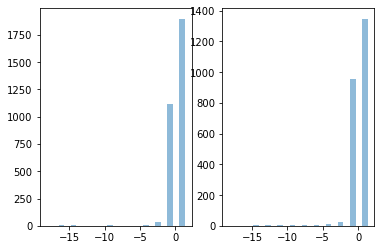

0.73 Magnesium - C1: 0.03044396613172152 , C2: -0.033648798662769236


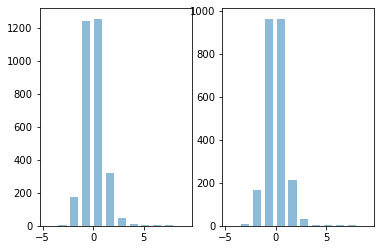

0.56 Temp - C1: -0.03884563943203763 , C2: 0.020468145517546114


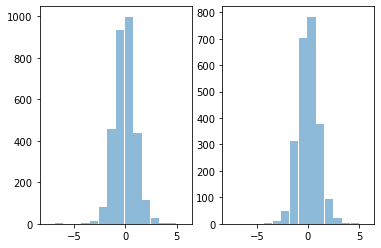

0.308 Lactate - C1: 0.029112984570719917 , C2: -0.02377589198548313


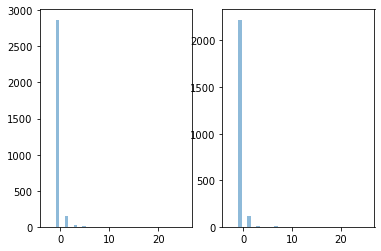



2,0
{'0_ShockIndex_HR': 1.0, '0_PartialSOFA_SBP': 1.0, '1_PartialSOFA_SBP': 1.0, '4_PartialSOFA_SBP': 1.0, '10_PartialSOFA_SBP': 1.0, '13_PartialSOFA_SBP': 1.0, 'Phosphate': 0.5, 'BUN': 0.492, 'Platelets': 0.471, 'Magnesium': 0.422}
1.0 0_ShockIndex_HR - C1: 0.0 , C2: 0.0
1.0 0_PartialSOFA_SBP - C1: 0.0 , C2: 0.0
1.0 1_PartialSOFA_SBP - C1: 0.0 , C2: 0.0
1.0 4_PartialSOFA_SBP - C1: 0.0 , C2: 0.0
1.0 10_PartialSOFA_SBP - C1: 0.0 , C2: 0.0
1.0 13_PartialSOFA_SBP - C1: 0.0 , C2: 0.0
0.5 Phosphate - C1: 0.05968239670151555 , C2: -0.005165731978382824


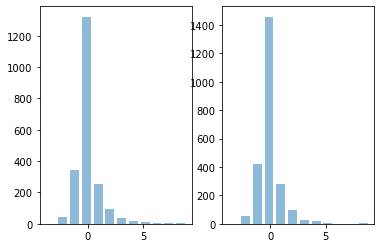

0.492 BUN - C1: 0.03929021170986566 , C2: -0.024992736386645804


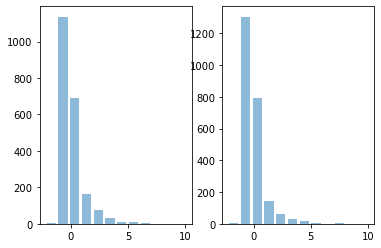

0.471 Platelets - C1: 0.04745839342310841 , C2: -0.018533564224435445


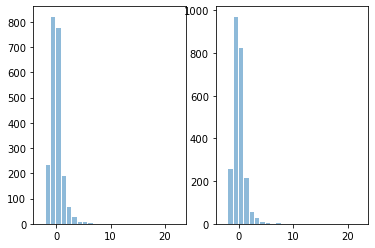

0.422 Magnesium - C1: 0.026988382060441372 , C2: -0.033648798662769236


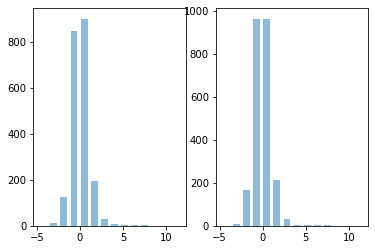



2,1
{'0_ShockIndex_HR': 1.0, '0_PartialSOFA_SBP': 1.0, '1_PartialSOFA_SBP': 1.0, '4_PartialSOFA_SBP': 1.0, '10_PartialSOFA_SBP': 1.0, '13_PartialSOFA_SBP': 1.0, '11_ShockIndex_HR': 0.79, 'ICULOS': 0.466, 'Phosphate': 0.214, '8_ShockIndex_HR': 0.21}
1.0 0_ShockIndex_HR - C1: 0.0 , C2: 0.0
1.0 0_PartialSOFA_SBP - C1: 0.0 , C2: 0.0
1.0 1_PartialSOFA_SBP - C1: 0.0 , C2: 0.0
1.0 4_PartialSOFA_SBP - C1: 0.0 , C2: 0.0
1.0 10_PartialSOFA_SBP - C1: 0.0 , C2: 0.0
1.0 13_PartialSOFA_SBP - C1: 0.0 , C2: 0.0
0.79 11_ShockIndex_HR - C1: -0.03633543981728562 , C2: 0.05275482156210658


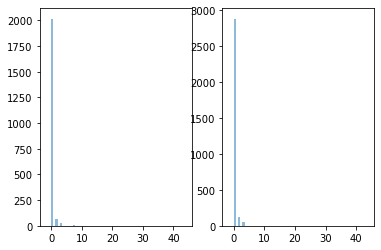

0.466 ICULOS - C1: 0.0277976764947677 , C2: -0.028884254463515776


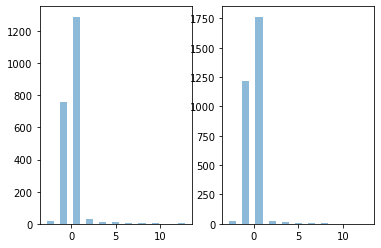

0.214 Phosphate - C1: 0.05968239670151555 , C2: 0.008640124384355423


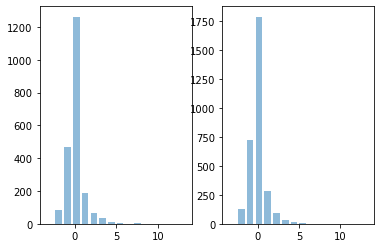

0.21 8_ShockIndex_HR - C1: -0.02160394772266293 , C2: 0.04995609180985852


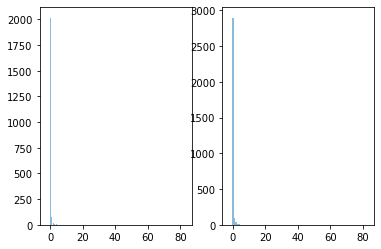

In [13]:
cluster_entrpy = 0
cntr = 0
n_columns = X_train.shape[1]
n_clusters = len(torch.unique(cluster_ids))
input_dim = X_train.shape[1]
mi_scores = {}
scaled_X_train = X_train
for i in range(n_clusters):
    for j in range(n_clusters):
        if i > j:
            joint_col_name = str(i) + "," + str(j)
            mi_scores[joint_col_name] = {}
            ci = torch.where(cluster_ids == i)[0]
            cj = torch.where(cluster_ids == j)[0]
            Xi = X_train[ci]
            Xj = X_train[cj]
            col_entrpy = 0
            p_vals = np.nan_to_num(ttest_ind(Xi, Xj, axis=0, equal_var=True))[1]
            for c in range(n_columns):
                mi_scores[joint_col_name][c] = np.round(np.exp(-p_vals[c]/0.05), 3)
                # print(column_names[c], ":", c_entropy)
            cntr += 1
            print("\n========\n")
            print(joint_col_name)
            sorted_dict = sorted(mi_scores[joint_col_name].items(), key=lambda item: -item[1])[:10]
            print({column_names[k]: v for k, v in sorted_dict})
            for k, v in sorted_dict:
                print(v, column_names[k], "- C1:", np.mean(scaled_X_train[ci][:,k]), ", C2:", np.mean(scaled_X_train[cj][:,k]))
                plot_hist(scaled_X_train[ci][:,k], scaled_X_train[cj][:,k])

## WDFD

Wasserstein Distance based feature discrimination

In [18]:
cluster_entrpy = 0
cntr = 0
n_columns = X_train.shape[1]
n_clusters = len(torch.unique(cluster_ids))
input_dim = X_train.shape[1]
mi_scores = {}
scaled_X_train = scale.inverse_transform(X_train)

for i in range(n_clusters):
    for j in range(n_clusters):
        if i > j:
            joint_col_name = str(i) + "," + str(j)
            mi_scores[joint_col_name] = {}
            ci = torch.where(cluster_ids == i)[0]
            cj = torch.where(cluster_ids == j)[0]
            Xi = X_train[ci]
            Xj = X_train[cj]
            col_entrpy = 0
            for c in range(n_columns):
                c_entropy = wd(Xi[:,c], Xj[:,c])
                col_entrpy += c_entropy
                mi_scores[joint_col_name][c] = np.round(c_entropy, 3)
                # print(column_names[c], ":", c_entropy)
            cluster_entrpy += col_entrpy/n_columns
            cntr += 1
            print("\n========\n")
            print("WDFD Analysis of Clusters: ", joint_col_name)
            sorted_dict = sorted(mi_scores[joint_col_name].items(), key=lambda item: -item[1])[:10]
            # print({column_names[k]: v for k, v in sorted_dict})
            print("|C{}| = {}, |C{}| = {}".format(i, len(ci), j, len(cj)))
            print("|C{}| = {:.3f}, |C{}| = {:.3f}".format(i, sum(y_train[ci])/len(ci), j, sum(y_train[cj])/len(cj)))
            for k, v in sorted_dict:
                print("MI =", v, "; Feature:", column_names[k], "- C1 Mean:", np.round(np.mean(scaled_X_train[ci][:,k]),3),\
                      ", C2 Mean:", np.round(np.mean(scaled_X_train[cj][:,k]),3))
                # print(scaled_X_train[cj][:,k])
                # plot_hist(scaled_X_train[ci][:,k], scaled_X_train[cj][:,k])



WDFD Analysis of Clusters:  1,0
|C1| = 1890, |C0| = 2458
|C1| = 0.032, |C0| = 0.115
MI = 0.86 ; Feature: CSRU - C1 Mean: 0.502 , C2 Mean: 0.147
MI = 0.789 ; Feature: MechVentLast8Hour - C1 Mean: 0.278 , C2 Mean: 0.661
MI = 0.672 ; Feature: MechVentDuration - C1 Mean: 1423.359 , C2 Mean: 2008.074
MI = 0.62 ; Feature: UrineOutputSum - C1 Mean: 9.254 , C2 Mean: 12.899
MI = 0.483 ; Feature: GCS_last - C1 Mean: 14.487 , C2 Mean: 12.74
MI = 0.454 ; Feature: PaO2_first - C1 Mean: 257.822 , C2 Mean: 201.619
MI = 0.449 ; Feature: GCS_median - C1 Mean: 13.827 , C2 Mean: 12.221
MI = 0.41 ; Feature: GCS_highest - C1 Mean: 14.758 , C2 Mean: 13.692
MI = 0.409 ; Feature: GCS_first - C1 Mean: 8.806 , C2 Mean: 10.807
MI = 0.396 ; Feature: NIMAP_highest - C1 Mean: 89.858 , C2 Mean: 97.255


WDFD Analysis of Clusters:  2,0
|C2| = 2402, |C0| = 2458
|C2| = 0.254, |C0| = 0.115
MI = 0.667 ; Feature: GCS_last - C1 Mean: 10.328 , C2 Mean: 12.74
MI = 0.55 ; Feature: BUN_last - C1 Mean: 34.09 , C2 Mean: 22.73


In [52]:
def NHFD_Single_Cluster_Analysis(X_train, cluster_ids, column_names):
    print("\nCluster Wise discriminative features (NHFD)")
    cluster_entrpy = 0
    cntr = 0
    n_columns = X_train.shape[1]
    n_clusters = len(torch.unique(cluster_ids))
    input_dim = X_train.shape[1]
    mi_scores = {}
    for i in range(n_clusters):
        mi_scores[i] = {}
        ci = torch.where(cluster_ids == i)[0]
        for c in range(n_columns):
            Xi_c = X_train[ci][:,c]
            Zc = []
            # Collect values from other clusters
            for j in range(n_clusters):
                if i != j:
                    cj = torch.where(cluster_ids == j)[0]                    
                    Xj_c = X_train[cj][:,c]
                    Zc = np.concatenate([Zc, Xj_c])

            col_entrpy = 0
            p_vals = np.nan_to_num(ttest_ind(Xi_c, Zc, axis=0, equal_var=True))[1]
#             p_vals = np.nan_to_num(wd(Xi_c, Zc))
#             p_vals = np.nan_to_num(calc_MI(Xi_c, Zc,0))
#             mi_scores[i][c] = np.round(np.exp(-p_vals/0.05), 3)
            mi_scores[i][c] = -np.log(p_vals + np.finfo(float).eps)*0.05
#             mi_scores[i][c] = p_vals

        print("\n========\n")
        print("|C{}| = {}".format(i, len(ci)))
        print("|C{}| = {:.3f}".format(i, sum(y_train[ci])/len(ci)))

        sorted_dict = sorted(mi_scores[i].items(), key=lambda item: -item[1])
        for feature, pval in sorted_dict:
            f = column_names[feature]
            print(f, "\t", pval, end='\t')
            for cluster_id in range(n_clusters):
                    c_cluster_id = torch.where(cluster_ids == cluster_id)[0]
                    X_cluster_f = X_train[c_cluster_id][:,feature]
                    print("({:.3f}, {:.3f})".format(np.round(np.mean(X_cluster_f),3), np.round(np.std(X_cluster_f),3)), end='\t')
            print('')


In [53]:
scaled_X_train = scale.inverse_transform(X_train)
NHFD_Single_Cluster_Analysis(scaled_X_train, cluster_ids, column_names)


Cluster Wise discriminative features (NHFD)


|C0| = 2374
|C0| = 0.112
SOFA 	 1.8021826694558578	(5.489, 3.802)	(5.860, 3.890)	(7.767, 4.471)	
CSRU 	 1.8021826694558578	(0.137, 0.343)	(0.507, 0.500)	(0.059, 0.235)	
GCS_lowest 	 1.8021826694554983	(9.082, 4.746)	(8.056, 5.020)	(7.506, 4.539)	
GCS_first 	 1.8021826694144498	(10.871, 4.549)	(8.770, 5.219)	(10.250, 4.722)	
Creatinine_last 	 1.8021826689009495	(1.132, 0.869)	(0.923, 0.423)	(1.979, 2.046)	
BUN_last 	 1.802171702741115	(22.278, 15.345)	(17.238, 9.475)	(35.342, 27.136)	
SAPS-I 	 1.8019308691607554	(13.318, 5.549)	(13.281, 6.281)	(15.858, 6.089)	
Creatinine_first 	 1.782105082381228	(1.164, 0.846)	(0.864, 0.396)	(1.992, 2.189)	
SICU 	 1.6910306357502796	(0.325, 0.466)	(0.189, 0.395)	(0.274, 0.446)	
K_first 	 1.6130027206298498	(4.087, 0.644)	(4.180, 0.604)	(4.269, 0.850)	
FiO2_first 	 1.6010254898894496	(0.754, 0.248)	(0.828, 0.232)	(0.784, 0.268)	
MechVentDuration 	 1.5471099501657675	(2020.914, 746.774)	(1440.874, 874.470)	(



|C1| = 1994
|C1| = 0.024
Length_of_stay 	 1.8021826694558578	(12.961, 9.691)	(9.987, 6.611)	(16.813, 16.526)	
CCU 	 1.8021826694558578	(0.168, 0.374)	(0.065, 0.248)	(0.186, 0.389)	
CSRU 	 1.8021826694558578	(0.137, 0.343)	(0.507, 0.500)	(0.059, 0.235)	
DiasABP_first 	 1.8021826694558578	(61.922, 12.605)	(59.335, 10.169)	(65.359, 17.346)	
GCS_first 	 1.8021826694558578	(10.871, 4.549)	(8.770, 5.219)	(10.250, 4.722)	
Glucose_first 	 1.8021826694558578	(149.557, 69.751)	(129.245, 41.472)	(166.254, 98.784)	
HR_first 	 1.8021826694558578	(88.461, 20.357)	(85.166, 14.450)	(94.522, 22.408)	
NIDiasABP_first 	 1.8021826694558578	(61.151, 16.635)	(55.958, 13.243)	(63.164, 19.636)	
NIMAP_first 	 1.8021826694558578	(80.201, 17.002)	(73.965, 13.251)	(82.952, 20.616)	
NISysABP_first 	 1.8021826694558578	(122.622, 25.238)	(113.410, 19.990)	(126.441, 29.549)	
Temp_first 	 1.8021826694558578	(36.640, 1.022)	(36.344, 0.860)	(36.692, 1.174)	
GCS_last 	 1.8021826694558578	(12.744, 3.116)	(14.489, 1.295)



|C2| = 2382
|C2| = 0.268
SAPS-I 	 1.8021826694558578	(13.318, 5.549)	(13.281, 6.281)	(15.858, 6.089)	
SOFA 	 1.8021826694558578	(5.489, 3.802)	(5.860, 3.890)	(7.767, 4.471)	
Length_of_stay 	 1.8021826694558578	(12.961, 9.691)	(9.987, 6.611)	(16.813, 16.526)	
Weight 	 1.8021826694558578	(79.536, 20.775)	(76.877, 16.483)	(87.256, 28.744)	
CSRU 	 1.8021826694558578	(0.137, 0.343)	(0.507, 0.500)	(0.059, 0.235)	
DiasABP_first 	 1.8021826694558578	(61.922, 12.605)	(59.335, 10.169)	(65.359, 17.346)	
Glucose_first 	 1.8021826694558578	(149.557, 69.751)	(129.245, 41.472)	(166.254, 98.784)	
HR_first 	 1.8021826694558578	(88.461, 20.357)	(85.166, 14.450)	(94.522, 22.408)	
MAP_first 	 1.8021826694558578	(83.045, 21.489)	(79.595, 14.609)	(90.792, 37.629)	
NIMAP_first 	 1.8021826694558578	(80.201, 17.002)	(73.965, 13.251)	(82.952, 20.616)	
NISysABP_first 	 1.8021826694558578	(122.622, 25.238)	(113.410, 19.990)	(126.441, 29.549)	
SaO2_first 	 1.8021826694558578	(96.956, 1.429)	(97.376, 1.364)	(95.6

## Local Training

In [33]:
print("\n####################################################################################\n")
print("Training Local Networks")
model = es.load_checkpoint(model)

es = EarlyStoppingCAC(dataset=suffix)

qs, z_train = model(torch.FloatTensor(np.array(X_train)).to(args.device), output="latent")
q_train = qs[0]
cluster_id_train = torch.argmax(q_train, axis=1)

# X_latents_data_loader = list(zip(z_train, cluster_id_train, y_train))
X_latents_data_loader = list(zip(z_train.to(args.device),q_train, y_train))

train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
    batch_size=1024, shuffle=False)

B = []

# plot(model, torch.FloatTensor(np.array(X_train)).to(args.device), y_train,\
#      torch.FloatTensor(np.array(X_test)).to(args.device), y_test)

# Post clustering training
for e in range(N_EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    acc = 0

    # model.ae.train() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].train()

    # Full training of local networks
    for batch_idx, (X_latents, q_batch, y_batch) in enumerate(train_loader_latents):
        # torch.autograd.set_detect_anomaly(True)

        classifier_labels = np.zeros(len(X_latents))
        # Choose classifier for a point probabilistically
        if args.attention == True:
            for j in range(len(X_latents)):
                classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q_batch[j].detach().numpy())
        else:
            classifier_labels = torch.argmax(q_batch, axis=1).data.cpu().numpy()

        for k in range(args.n_clusters):
            idx_cluster = np.where(classifier_labels == k)[0]
            X_cluster = X_latents[idx_cluster]
            y_cluster = y_batch[idx_cluster]

            classifier_k, optimizer_k = model.classifiers[k]
            # Do not backprop the error to encoder
            y_pred_cluster = classifier_k(X_cluster.detach())
            cluster_loss = torch.mean(criterion(y_pred_cluster, y_cluster))
            optimizer_k.zero_grad()
            cluster_loss.backward(retain_graph=True)
            optimizer_k.step()

    # model.ae.eval() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].eval()

    train_preds = torch.zeros((len(z_train), 2))
    train_loss = 0

    # Weighted predictions
    q_train, z_train = model(torch.FloatTensor(X_train).to(args.device), output="latent")
    q_train = q_train[0]
    cluster_ids_train = torch.argmax(q_train, axis=1)

    for j in range(model.n_clusters):
        cluster_id = np.where(cluster_ids_train == j)[0]
        X_cluster = z_train
        y_cluster = torch.Tensor(y_train[cluster_id]).type(torch.LongTensor)

        # Ensemble train loss
        cluster_preds = model.classifiers[j][0](X_cluster)
        train_preds[:,0] += q_train[:,j]*cluster_preds[:,0]
        train_preds[:,1] += q_train[:,j]*cluster_preds[:,1]

        X_cluster = z_train[cluster_id]
        cluster_preds = model.classifiers[j][0](X_cluster)
        train_loss += torch.sum(q_train[cluster_id,j]*criterion(cluster_preds, y_cluster))
        # B.append(torch.max(torch.linalg.norm(X_cluster, axis=1), axis=0).values)


    train_loss /= len(z_train)
    e_train_loss = torch.mean(criterion(train_preds, torch.Tensor(y_train).type(torch.LongTensor)))

    # Evaluate model on Validation set
    qs, z_val = model(torch.FloatTensor(X_val).to(args.device), output="latent")
    q_val = qs[0]
    cluster_ids_val = torch.argmax(q_val, axis=1)
    preds = torch.zeros((len(z_val), 2))

    # Weighted predictions
    for j in range(model.n_clusters):
        cluster_id = np.where(cluster_ids_val == j)[0]
        X_cluster = z_val
        cluster_preds = model.classifiers[j][0](X_cluster)
        preds[:,0] += q_val[:,j]*cluster_preds[:,0]
        preds[:,1] += q_val[:,j]*cluster_preds[:,1]

    val_f1  = f1_score(y_val, np.argmax(preds.detach().numpy(), axis=1))
    val_auc = roc_auc_score(y_val, preds[:,1].detach().numpy())
    val_sil = silhouette_new(z_val.data.cpu().numpy(), cluster_ids_val.data.cpu().numpy(), metric='euclidean')

    val_loss = torch.mean(criterion(preds, torch.Tensor(y_val).type(torch.LongTensor)))
    # record validation loss
    # valid_losses.append(loss.item())

    # calculate average loss over an epoch
    # valid_loss = np.average(valid_losses)
    # avg_valid_losses.append(valid_loss)

    epoch_len = len(str(N_EPOCHS))

    print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                 f'train_loss: {train_loss:.3f} ' +
                 f'valid_loss: {val_loss:.3f} '  +
                 f'valid_F1: {val_f1:.3f} '  +
                 f'valid_AUC: {val_auc:.3f} ' +
                 f'valid_Sil: {val_sil:.3f}')

    print(print_msg)

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    es([val_f1, val_auc], model)
    if es.early_stop == True:
        train_losses.append(train_loss.item())
        e_train_losses.append(e_train_loss.item())
        sil_scores.append(silhouette_new(z_train.data.cpu().numpy(), cluster_ids_train.data.cpu().numpy(), metric='euclidean'))
        nhfd_scores.append(calculate_nhfd(X_train,  cluster_ids_train))
        mifd_scores.append(calculate_MIFD(X_train,  cluster_ids_train))
        # model_complexity.append(calculate_bound(model, B, len(z_train)))
        break



####################################################################################

Training Local Networks
Loading Best model with score:  [0.8140828700936527, 0.9156538566041738]

[ 32/100] train_loss: 0.043 valid_loss: 0.150 valid_F1: 0.663 valid_AUC: 0.917 valid_Sil: 0.213

[ 32/100] train_loss: 0.042 valid_loss: 0.148 valid_F1: 0.668 valid_AUC: 0.917 valid_Sil: 0.213
EarlyStopping counter: 1 out of 7

[ 32/100] train_loss: 0.042 valid_loss: 0.150 valid_F1: 0.667 valid_AUC: 0.917 valid_Sil: 0.213
EarlyStopping counter: 2 out of 7

[ 32/100] train_loss: 0.042 valid_loss: 0.149 valid_F1: 0.667 valid_AUC: 0.917 valid_Sil: 0.213
EarlyStopping counter: 3 out of 7

[ 32/100] train_loss: 0.042 valid_loss: 0.152 valid_F1: 0.653 valid_AUC: 0.918 valid_Sil: 0.213

[ 32/100] train_loss: 0.042 valid_loss: 0.149 valid_F1: 0.670 valid_AUC: 0.917 valid_Sil: 0.213
EarlyStopping counter: 1 out of 7

[ 32/100] train_loss: 0.042 valid_loss: 0.150 valid_F1: 0.655 valid_AUC: 0.918 valid_Sil: 0.213



NameError: name 'mifd_scores' is not defined

## Evaluating on Test Data

In [ ]:
print("\n####################################################################################\n")
print("Evaluating Test Data with k = ", args.n_clusters, " Attention = ", args.attention)

# Load best model trained from local training phase
model = es.load_checkpoint(model)

# # Evaluate model on Test dataset
qs, z_test = model(torch.FloatTensor(X_test).to(args.device), output="latent")
q_test = qs[0]
cluster_ids = torch.argmax(q_test, axis=1)
# cluster_ids = np.argmax(distance_matrix(z_test.data.cpu().numpy(), model.cluster_layer.data.cpu().numpy()), axis=1)
test_preds_e = torch.zeros((len(z_test), 2))

test_loss = 0
e_test_loss = 0
local_sum_loss = 0

# Weighted predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    X_cluster = z_test
    cluster_test_preds = model.classifiers[j][0](X_cluster)
    test_preds_e[:,0] += q_test[:,j]*cluster_test_preds[:,0]
    test_preds_e[:,1] += q_test[:,j]*cluster_test_preds[:,1]

e_test_loss = torch.mean(criterion(test_preds_e, torch.Tensor(y_test).type(torch.LongTensor)))
e_test_f1 = f1_score(y_test, np.argmax(test_preds_e.detach().numpy(), axis=1))
e_test_auc = roc_auc_score(y_test, test_preds_e[:,1].detach().numpy())
e_test_acc = accuracy_score(y_test, np.argmax(test_preds_e.detach().numpy(), axis=1))
e_test_nhfd = calculate_nhfd(X_test, cluster_ids)

test_preds = torch.zeros((len(z_test), 2))

# Hard local predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    X_cluster = z_test[cluster_id]
    y_cluster = torch.Tensor(y_test[cluster_id]).type(torch.LongTensor)
    cluster_test_preds = model.classifiers[j][0](X_cluster)
    test_preds[cluster_id,:] = cluster_test_preds
    local_sum_loss += torch.sum(q_test[cluster_id,j]*criterion(cluster_test_preds, y_cluster))

test_f1 = f1_score(y_test, np.argmax(test_preds.detach().numpy(), axis=1))
test_auc = roc_auc_score(y_test, test_preds[:,1].detach().numpy())
test_acc = accuracy_score(y_test, np.argmax(test_preds.detach().numpy(), axis=1))
test_loss = torch.mean(criterion(test_preds, torch.Tensor(y_test).type(torch.LongTensor)))
local_sum_loss /= len(X_test)

test_losses.append(test_loss.item())
e_test_losses.append(e_test_loss.item())
local_sum_test_losses.append(local_sum_loss.item())

# enablePrint()
# print("Run #{}".format(r))

print('Loss Metrics - Test Loss {:.3f}, E-Test Loss {:.3f}, Local Sum Test Loss {:.3f}'.format(test_loss, e_test_loss, local_sum_loss))

print('Clustering Metrics     - Acc {:.4f}'.format(acc), ', nmi {:.4f}'.format(nmi),\
      ', ari {:.4f}, NHFD {:.3f}'.format(ari, e_test_nhfd))

print('Classification Metrics - Test F1 {:.3f}, Test AUC {:.3f}, Test ACC {:.3f}'.format(test_f1, test_auc, test_acc),\
    ', E-Test F1 {:.3f}, E-Test AUC {:.3f}, E-Test ACC {:.3f}'.format(e_test_f1, e_test_auc, e_test_acc))

print("\n")
f1_scores.append(e_test_f1)
auc_scores.append(e_test_auc)
# acc_scores.append(e_test_acc)
mifd_scores = []
print("\n")
print("Test F1: ", f1_scores)
print("Test AUC: ", auc_scores)

print("Sil scores: ", sil_scores)
print("NHFD: ", nhfd_scores)
print("MIFD: ", mifd_scores)

print("Train Loss: ", train_losses)
print("E-Train Loss: ", e_train_losses)

print("Test Loss: ", test_losses)
print("E-Test Loss: ", e_test_losses)
print("Local Test Loss: ", local_sum_test_losses)

print("Model Complexity: ", model_complexity)

# enablePrint()
print("Dataset\tk\tF1\tAUC\tACC\tSIL\tNHFD\tMIFD\tW-NHFD")

print("{}\t{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}".format\
    (args.dataset, args.n_clusters, np.average(f1_scores), np.average(auc_scores),\
    np.average(acc_scores), np.average(sil_scores), np.average(nhfd_scores),\
    np.average(mifd_scores), np.average(w_nhfd_scores)))

print("\n")

### K-Means feature segregation ... 

In [35]:
from sklearn.metrics.cluster import adjusted_rand_score as ari_score
km = KMeans(n_clusters=args.n_clusters, n_init=20)
cluster_ids = torch.argmax(q_train, axis=1).data.cpu().numpy()
n_features = X_train.shape[1]
nmi_scores = {}
ari_scores = {}
nmi_sum = 0
ari_sum = 0
for feature in range(n_features):
    feature_labels = km.fit(X_train[:,feature].reshape(-1,1)).labels_
    nmi = nmi_score(feature_labels, cluster_ids)
    ari = ari_score(feature_labels, cluster_ids)
    nmi_sum += nmi
    ari_sum += ari
    nmi_scores[column_names[feature]] = np.round(nmi, 3)
    ari_scores[column_names[feature]] = np.round(ari, 3)

nmi_sum, ari_sum
{k: v for k, v in sorted(nmi_scores.items(), key=lambda item: item[1])}
{k: v for k, v in sorted(ari_scores.items(), key=lambda item: item[1])}

NameError: name 'KMeans' is not defined

## Knowledge Distilation based Feature Importance

/Users/shivin/miniconda/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:366: NumbaWarning: The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Training data


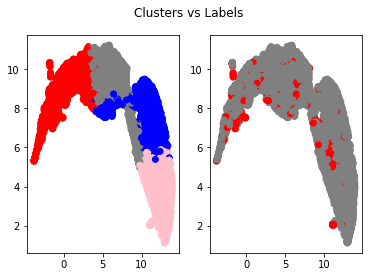

Cluster #  0 sized:  5645 +/- 0.05845881310894597
[('ICULOS', 0.551), ('Temp', 0.063), ('hospital', 0.046), ('HR', 0.035), ('7_ShockIndex_HR', 0.024), ('O2Sat', 0.02), ('23_PartialSOFA_SBP', 0.02), ('17_PartialSOFA_SBP', 0.019), ('Calcium', 0.012), ('6_ShockIndex_HR', 0.011)]

Cluster #  1 sized:  6094 +/- 0.12881522809320645
[('ICULOS', 0.397), ('O2Sat', 0.178), ('HR', 0.041), ('22_PartialSOFA_SBP', 0.03), ('7_PartialSOFA_SBP', 0.022), ('Calcium', 0.02), ('Temp', 0.019), ('EtCO2', 0.017), ('WBC', 0.017), ('19_PartialSOFA_SBP', 0.015)]

Cluster #  2 sized:  5888 +/- 0.04228940217391304
[('ICULOS', 0.39), ('Temp', 0.161), ('WBC', 0.057), ('7_PartialSOFA_SBP', 0.044), ('HR', 0.036), ('hospital', 0.036), ('O2Sat', 0.023), ('Magnesium', 0.023), ('Lactate', 0.022), ('16_PartialSOFA_SBP', 0.022)]

Cluster #  3 sized:  5057 +/- 0.05774174411706545
[('ICULOS', 0.73), ('Temp', 0.058), ('hospital', 0.036), ('17_PartialSOFA_SBP', 0.015), ('4_ShockIndex_HR', 0.014), ('7_PartialSOFA_SBP', 0.012), (

In [34]:
####################################################################################
####################################################################################
####################################################################################
################################### Feature Imp. ###################################
####################################################################################
####################################################################################
####################################################################################

plot(model, torch.FloatTensor(X_train).to(args.device), y_train, labels=None)

regs = [GradientBoostingRegressor(random_state=0) for _ in range(args.n_clusters)]
qs, z_train = model(torch.FloatTensor(X_train).to(args.device), output="latent")
q_train = qs[0]
cluster_ids = torch.argmax(q_train, axis=1)
preds_e = torch.zeros((len(z_train), 2))
feature_importances = np.zeros((args.n_clusters, args.input_dim))

# Weighted predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    # X_cluster = z_test[cluster_id]
    X_cluster = z_train
    cluster_preds = model.classifiers[j][0](X_cluster)
    # print(q_test, cluster_preds[:,0])
    preds_e[:,0] += q_train[:,j]*cluster_preds[:,0]
    preds_e[:,1] += q_train[:,j]*cluster_preds[:,1]

for j in range(model.n_clusters):
    cluster_id = torch.where(cluster_ids == j)[0]
    X_cluster = X_train[cluster_id]
    if args.attention == True:
        y_cluster = preds_e[cluster_id][:,1]
    else:
        y_cluster = preds[cluster_id][:,1]

    # Some test data might not belong to any cluster
    if len(cluster_id) > 0:
        regs[j].fit(X_cluster, y_cluster.detach().cpu().numpy())
        best_features = np.argsort(regs[j].feature_importances_)[::-1][:10]
        feature_importances[j,:] = regs[j].feature_importances_
        print("Cluster # ", j, "sized: ", len(cluster_id), "+/-", sum(y_train[cluster_id])/len(cluster_id))
        print(list(zip(column_names[best_features], np.round(regs[j].feature_importances_[best_features], 3))))
        print("=========================\n")


## Baseline Model

In [1]:
f1_scores, auc_scores, acc_scores = [], [], []
if args.verbose == "False":
    blockPrint()

for r in range(args.n_runs):
    model = NNClassifier(args, input_dim=args.input_dim)
    device = args.device

    N_EPOCHS = args.n_epochs
    es = EarlyStopping(dataset=args.dataset)

    for e in range(1, N_EPOCHS):
        epoch_loss = 0
        epoch_auc = 0
        epoch_f1 = 0
        auc = 0
        model.train()
        for X_batch, y_batch, _ in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred, train_loss = model.fit(X_batch, y_batch)
            epoch_loss += train_loss

            f1 = f1_score(np.argmax(y_pred, axis=1), y_batch.detach().numpy(), average="macro")
            auc = multi_class_auc(y_batch, y_pred, args.n_classes)
            epoch_auc += auc.item()
            epoch_f1 += f1.item()

        model.classifier.eval()
        val_pred, _ = model(torch.FloatTensor(np.array(X_val)).to(args.device))
        val_loss = nn.CrossEntropyLoss(reduction='mean')(val_pred, torch.tensor(y_val).to(device))

        val_f1 = f1_score(np.argmax(val_pred.detach().numpy(), axis=1), y_val, average="macro")
        val_auc = multi_class_auc(y_val, val_pred.detach().numpy(), args.n_classes)
        es([val_f1, val_auc], model)

        print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | ',
        	f'Train F1: {epoch_f1/len(train_loader):.3f} | Train Auc: {epoch_auc/len(train_loader):.3f} | ',
        	f'Val F1: {val_f1:.3f} | Val Auc: {val_auc:.3f} | Val Loss: {val_loss:.3f}')

        if es.early_stop == True:
            break


    ####################################################################################
    ####################################################################################
    ####################################################################################
    ###################################### Testing #####################################
    ####################################################################################
    ####################################################################################
    ####################################################################################

    print("\n####################################################################################\n")
    print("Evaluating Test Data")

    # Load best model trained from local training phase
    model = es.load_checkpoint(model)
    model.classifier.eval()
    test_pred, _ = model(torch.FloatTensor(np.array(X_test)).to(args.device))
    test_loss = nn.CrossEntropyLoss(reduction='mean')(test_pred, torch.tensor(y_test).to(device))

    test_f1 = f1_score(np.argmax(test_pred.detach().numpy(), axis=1), y_test, average="macro")
    test_auc = multi_class_auc(y_test, test_pred.detach().numpy(), args.n_classes)
    test_acc = accuracy_score(np.argmax(test_pred.detach().numpy(), axis=1), y_test)

    y_preds = np.argmax(test_pred.detach().numpy(), axis=1)
    # print(confusion_matrix(y_test, y_preds))

    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | ',
    	f'Train F1: {epoch_f1/len(train_loader):.3f} | Train Auc: {epoch_auc/len(train_loader):.3f}| ',
    	f'Test F1: {test_f1:.3f} | Test Auc: {test_auc:.3f} | Test Loss: {test_loss:.3f}')

    print("\n####################################################################################\n")
    f1_scores.append(test_f1)
    auc_scores.append(test_auc)
    acc_scores.append(test_acc)

    # reg = GradientBoostingRegressor(random_state=0)

    # reg.fit(X_test, y_test)
    # best_features = np.argsort(reg.feature_importances_)[::-1][:10]
    # print("Best Features ")
    # print(column_names[best_features])
    # print("=========================\n")

enablePrint()
print("F1:", f1_scores)
print("AUC:", auc_scores)
print("ACC:", acc_scores)
print("Dataset\tk\tF1\tAUC\tACC")
print("{}\t{}\t{:.3f}\t{:.3f}\t{:.3f}".format(args.dataset, args.n_clusters, np.average(f1_scores), np.average(auc_scores), np.average(acc_scores)))

NameError: name 'args' is not defined